# Apply BERT to Solve a Cannabis Product Classification Problem 

**Authors:** Wenhao Pan and Lance Mathias, UC Berkeley, Spring 2022.

## Table of Contents

* [Introduction](#Introduction)
* [Basic Setup](#Basic-Setup)
* [One Label](#One-Label)
    * [Load the Dataset](#Load-the-Dataset)
* [All the Labels](#All-the-Labels)
* [Prediction](#Prediction)


## Introduction

In this notebook, we explore [BERT model](https://en.wikipedia.org/wiki/BERT_(language_model), which was created and published in 2018 by Google, on our cannabis product dataset. By running through this notebook, we are able to

* Fine-tune a BERT model for a single label, which is a binary classification task (*One Label*)
* Fine-tune multiple BERT models for multiple labels consecutively, which is a set of binary classification tasks (*All Label*)
* Use the fine-tuned BERT models to make the predictions (*Prediction*)

Within in each section, it is recommended to run the code cells in order. All the code cells in *Basic Setup* section should always be run before any other section.

**Note**: This is a google colab version of the `bert.ipynb`, which is designed for running locally (if you have an GPU), in the original repository.

## Basic Setup

Run the following cell to connect the notebook to your google drive so that you can save the fine-tuned model and predictions to the folder `BERT` permanently if you want. 

Run the following cell to install all the packages that will be used later through `pypi`.

Run the following cell to import all the packages and functions that will be used later. `MODEL_NAME` defines which pre-trained label we want to use. Here, we are using `bert-base-uncased` which can be found [here](https://huggingface.co/bert-base-uncased).

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import os


MODEL_NAME = "bert-base-uncased" # the name of the pre-trained model we want to use
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
from datasets import load_dataset, load_metric, Dataset

from sklearn.model_selection import train_test_split 
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score, confusion_matrix

from gensim.parsing import remove_stopwords, strip_numeric, strip_punctuation, strip_multiple_whitespaces

import optuna
from optuna.samplers import CmaEsSampler, TPESampler

import sqlite3

Run the following cell to confirm we are using GPU.  
NOTE: Although we now have the ability to use GPU on Mac, this notebook still uses CPU only on Mac becuase the datasets aren't transferred to GPU memory.

In [20]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


Run the following cell to confirm we have the dataset loaded. Otherwise, you need to upload the dataset (`in_sample.csv` and `out_sample.csv`) to the `BERT` folder created by the previous code cell in your google drive. These two csv files can be downloaded from [here](https://drive.google.com/file/d/1yYhdvl2BRdOW6cUT2k4HcQrymEBRZrZD/view?usp=sharing) and [here](https://drive.google.com/file/d/1xXFebXJaaaWG8lx294J56XevfZlI2NVl/view?usp=sharing).

In [21]:
assert os.path.exists("in_sample.csv") and os.path.exists("out_sample.csv"), "Raw dataset was not detected. You need to upload the dataset first!"

Run the following cell to load the helper functions we need later.

In [22]:
def clean_data(df, field, labels, remove_punctuations=False, remove_stop_words=False, remove_digits=False, minimal=False):
    """Binarizes labels for given dataframe, and exports cleaned dataframes

    Args:
        df (pd.dataframe): dataframe with label columns (see LABELS above)
        field (str): the name of the input field
        labels (list[str]): labels we currently consider
        remove_punctuations (boolean): remove punctuations from the description field if True
        remove_stop_words (boolean): remove stop words from the description field if True
        remove_digits (boolean): remove digits from the description field if True
        minimal (boolean): only keep the description and label fields if True

    Returns:
        df_clean (pd.dataframe): cleaned dataframe with binarized labels
    """
    df_clean = df.dropna(subset=[field])

    # ensure label fields are all numerical
    for label in labels:
        df_clean = df_clean[(df_clean[label] == 0) | (df_clean[label] == 1) | (df_clean[label] == '0') | (df_clean[label] == '1')]
        df_clean[label] = pd.to_numeric(df_clean[label])
    
    # remove punctuations if wanted
    if remove_punctuations:
        df_clean[field] = df_clean[field].apply(strip_punctuation)

    # remove stopwords if wanted 
    if remove_stop_words:
        df_clean[field] = df_clean[field].apply(remove_stopwords)
    
    # remove digits if wanted
    if remove_digits:
        df_clean[field] = df_clean[field].apply(strip_numeric)

    # drop unnecessary columns
    if minimal:
        df_clean = df_clean[[field] + labels]

    df_clean[field] = df_clean[field].astype(str)
    df_clean[field] = df_clean[field].str.lower() # lowercase all characters
    df_clean[field] = df_clean[field].apply(strip_multiple_whitespaces) # remove repeating whitespace
    df_clean = df_clean.replace(to_replace=[''], value=np.nan).dropna(subset=[field]) # drop empty field
    
    return df_clean


def load_data(field, labels, remove_punctuations=False, remove_stop_words=False, remove_digits=False, minimal=False):
    """Loads in_sample and out_sample data, cleans them, and exports clean csv files

    Args:
        field (str): the name of the input field
        labels (list[str]): labels we currently consider
        remove_punctuations (boolean): remove punctuations from the description field if True
        remove_stop_words (boolean): remove stop words from the description field if True
        remove_digits (boolean): remove digits from the description field if True
        minimal (boolean): only keep the description and label fields if True

    Returns:
        clean_insample (pd.DataFrame): Training Dataset
        clean_outsample (pd.DataFrame): Testing Dataset
    """
    # Check that data is downloaded
    assert os.path.exists("in_sample.csv"), "Need to download in_sample.csv first!"
    assert os.path.exists("out_sample.csv"), "Need to download out_sample.csv first!"

    insample = pd.read_csv("in_sample.csv")
    clean_insample = clean_data(insample, field, labels, remove_punctuations, remove_stop_words, remove_digits, minimal)
    clean_insample.to_csv('clean_in_sample.csv', index=False)

    outsample = pd.read_csv("out_sample.csv")
    clean_outsample = clean_data(outsample, field, labels, remove_punctuations, remove_stop_words, remove_digits, minimal)
    clean_outsample.to_csv('clean_out_sample.csv', index=False) 

    return clean_insample, clean_outsample


## One Label

In this section, we fine-tune the BERT model on a single label. 

### Load the Dataset

Change `LABELS` and `LABEL` to the target label.

In [23]:
LABELS = ['Intoxication'] 
LABEL = 'Intoxication'

Here we chose **not** to remove any stopword or digit, but you can choose differently. 

In [24]:
raw_insample = pd.read_csv("in_sample.csv")
raw_outsample = pd.read_csv("out_sample.csv")
clean_insample, clean_outsample = load_data("straindescription", LABELS, remove_stop_words=False, remove_digits=False, minimal=True)

Comparsion between raw and cleaned description field

In [25]:
raw_outsample.iloc[1, 1]

'"Blue Dream" Agrijuana --- THC = 23.70%   \nBlue Dream, a sativa-dominant hybrid originating in California, has achieved legendary status among West Coast strains. Crossing a Blueberry indica with the sativa Haze, Blue Dream balances full-body relaxation with gentle cerebral invigoration. Novice and veteran consumers alike enjoy the level effects of Blue Dream, which ease you gently into a calm euphoria. Some Blue Dream phenotypes express a more indica-like look and feel, but the sativa-leaning variety remains most prevalent.'

In [26]:
clean_outsample.iloc[1, 0]

'"blue dream" agrijuana --- thc = 23.70% blue dream, a sativa-dominant hybrid originating in california, has achieved legendary status among west coast strains. crossing a blueberry indica with the sativa haze, blue dream balances full-body relaxation with gentle cerebral invigoration. novice and veteran consumers alike enjoy the level effects of blue dream, which ease you gently into a calm euphoria. some blue dream phenotypes express a more indica-like look and feel, but the sativa-leaning variety remains most prevalent.'

Split the insample dataset into the training and the validation sets.

In [27]:
val_size = 0.2
random_state = 10
train, val = train_test_split(clean_insample, test_size=val_size, random_state=random_state)
train.to_csv('train.csv', index=False)
val.to_csv('val.csv', index=False)

Load the training and testing set into a single object called `dataset`.

In [28]:
dataset = load_dataset('csv', data_files={'train': ['train.csv'], 'val': ['val.csv'], 'test': ['clean_out_sample.csv']})

Using custom data configuration default-8d76423b098d5219


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-8d76423b098d5219/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [29]:
dataset

DatasetDict({
    train: Dataset({
        features: ['straindescription', 'Intoxication'],
        num_rows: 7276
    })
    val: Dataset({
        features: ['straindescription', 'Intoxication'],
        num_rows: 1820
    })
    test: Dataset({
        features: ['straindescription', 'Intoxication'],
        num_rows: 5578
    })
})

In [30]:
dataset['train'][0] # first observation in the training set

{'Intoxication': 0,
 'straindescription': 'indica kief mix (56.6% thc) by cannasol --- indica // 1g for $25 // by cannasol'}

### Tokenize the textual input

The following cell is the collection of the tokenization hyperparameters.

In [31]:
padding = 'max_length' # padding strategy
padding_side = 'right' # the side on which the model should have padding applied
truncation = True # truncate strategy
truncation_side = 'right' # the side on which the model should have truncation applied
max_len = 150 # maximum length to use by one of the truncation/padding parameters
output_attentions = True # controls whether attention tensors are exposed

Load the pre-trained tokenizer. We padded or truncated the textual input from the right currently. 

In [32]:
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    padding_side=padding_side,
    truncation_side=truncation_side
)
tokenizer

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

Define the helper function for preprocessing/tokenizing the data. We can add more arguments in the call `tokenizer()` below to customize it. See more details [here](https://huggingface.co/docs/transformers/v4.18.0/en/main_classes/tokenizer#transformers.PreTrainedTokenizerFast.__call__).

In [33]:
def preprocess_function(examples):
    """
    Preprocess the description field
    ---
    Arguments:
    examples (str, List[str], List[List[str]]: the sequence or batch of sequences to be encoded/tokenized

    Returns:
    tokenized (transformers.BatchEncoding): tokenized descriptions 
    """
    tokenized = tokenizer(
        examples["straindescription"],
        padding=padding,
        truncation=truncation,
        max_length=max_len
    )

    return tokenized

Preprocess the textual field `straindescription` and edit the tokenized dataset so that it is acceptable to the model

In [34]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns("straindescription")
tokenized_dataset = tokenized_dataset.rename_column(LABEL, "label")
tokenized_dataset

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7276
    })
    val: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1820
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5578
    })
})

### Train (fine-tune) the model

Set up the metrics. See the [reference](https://huggingface.co/metrics).

In [37]:
val_eval = {}
test_eval = {}
metric_acc = load_metric("accuracy")
metric_f1 = load_metric("f1")
metric_precision = load_metric("precision")
metric_recall = load_metric("recall")
metric_auc = load_metric("roc_auc")

def compute_metrics(eval_pred):
    """
    Compute the metrics 
    ---
    Arguments:
    eval_pred (tuple): the predicted logits and truth labels

    Returns:
    metrics (dict{str: float}): contains the computed metrics 
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    prediction_scores = np.max(logits, axis=-1)
    print(logits.shape, labels.shape)
    print(predictions.shape, prediction_scores.shape)

    pred_true = np.count_nonzero(predictions)
    pred_false = predictions.shape[0] - pred_true
    actual_true = np.count_nonzero(labels)
    actual_false = labels.shape[0] - actual_true

    acc = metric_acc.compute(predictions=predictions, references=labels)['accuracy']
    f1 = metric_f1.compute(predictions=predictions, references=labels)['f1']
    precision = metric_precision.compute(predictions=predictions, references=labels)['precision']
    recall = metric_recall.compute(predictions=predictions, references=labels)['recall']
    roc_auc = metric_auc.compute(prediction_scores=predictions, references=labels)['roc_auc']
    matthews_correlation = matthews_corrcoef(y_true=labels, y_pred=predictions)
    cohen_kappa = cohen_kappa_score(y1=labels, y2=predictions)

    tn, fp, fn, tp = confusion_matrix(y_true=labels, y_pred=predictions).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    informedness = specificity + sensitivity - 1

    metrics = {
        "pred_true": pred_true,
        "pred_false": pred_false,
        "actual_true": actual_true,
        "actual_false": actual_false,
        "accuracy": acc,
        "f1_score": f1,
        "precision": precision,
        "recall": recall,
        "roc_auc": roc_auc,
        "matthews_correlation": matthews_correlation,
        "cohen_kappa": cohen_kappa,
        "true_negative": tn,
        "false_positive": fp,
        "false_negative": fn,
        "true_positive": tp,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "informedness": informedness
    }
    return metrics

The following cell is the collection of all the [model](https://huggingface.co/docs/transformers/v4.18.0/en/main_classes/tokenizer#transformers.PreTrainedTokenizerFast.__call__) and [opimization](https://huggingface.co/docs/transformers/v4.18.0/en/main_classes/trainer#transformers.TrainingArguments) hyperparameters we were using.

In [38]:
# model hyperparameters
classifier_dropout = 0.15 # dropout ratio for the classification head
num_classes = 2 # number of classes

# optimization hyperparameters ###
model_dir = "bert_" + LABEL
seed = 42 # random seed for splitting the data into batches
batch_size = 16 # batch size for both training and evaluation
grad_acc_steps = 4 # number of steps for gradient accumulation
lr = 5e-5 # initial learning rate
weight_decay = 2e-3 # weight decay to apply in the AdamW optimizer
epochs = 4 # total number of training epochs 
lr_scheduler = "cosine" # type of learning rate scheduler
strategy = "epoch" # strategy for logging, evaluation, and saving
hp_search_strategy = 'no' # don't save model at checkpoints to save space in hp search
steps = 100 # number of steps for logging, evaluation, and saving
eval_metric = "f1_score" # metric for selecting the best model
warmup_steps = 0 # number of "warmup" steps with reduced learning rate to warm up the model

Load the pre-trained model. We can change more model hyperparameters to change the pre-trained model architecture by adding more arguments in `from_pretrained` to customize the pre-trained model we load.


In [ ]:
def get_model_hp(trial):
  if trial:
    dropout = trial.suggest_float("classifier_dropout", 0.1, 0.2)
  else:
    dropout=classifier_dropout
  return AutoModelForSequenceClassification.from_pretrained(
      MODEL_NAME,
      classifier_dropout=dropout,
      num_labels=num_classes
  )

In [ ]:
# remove the cache
#!rm -rf $model_dir

hp_args = TrainingArguments(
    output_dir=model_dir,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=grad_acc_steps,
    learning_rate=lr,
    weight_decay=weight_decay, 
    num_train_epochs=epochs,
    lr_scheduler_type=lr_scheduler,
    evaluation_strategy=strategy,
    logging_strategy=strategy, 
    save_strategy=hp_search_strategy,
    eval_steps=steps,
    logging_steps=steps,
    save_steps=steps,
    seed=seed,
    load_best_model_at_end=False,
    metric_for_best_model=eval_metric,
    report_to="none",
    warmup_steps=warmup_steps
)

PyTorch: setting up devices


Set up the trainer function. See the [reference](https://huggingface.co/docs/transformers/v4.18.0/en/main_classes/trainer#transformers.Trainer).

In [ ]:
trainer = Trainer(
    model_init=get_model_hp,
    args=hp_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    tokenizer=tokenizer,   
    compute_metrics=compute_metrics,
)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": 0.15,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

Hyperparameter Tuning

In [ ]:
def hp_space(trial):
    return {
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5),
        "warmup_steps": trial.suggest_float("warmup_steps", 0, 100, step=20),
        "classifier_dropout": trial.suggest_float("classifier_dropout", 0.1, 0.2)
    }

best_run = trainer.hyperparameter_search(
    hp_space=hp_space,
    backend="optuna",
    n_trials=20,
    direction="maximize",
    sampler=CmaEsSampler(seed=seed),
    storage='sqlite:///study.db'
)

#### Train the model using best hyperparameters

In [ ]:
# TODO: get best hyperparameters from Optuna db file
best_hp = {'classifier_dropout': 0.15000951233705967, 'learning_rate': 3.837936994956064e-05, 'warmup_steps': 40.0, 'weight_decay': 0.14999589089115756}
optimized_lr = best_hp['learning_rate']
optimized_weight_decay = best_hp['weight_decay']
optimized_warmup_steps = best_hp['warmup_steps']
optimized_dropout = best_hp['classifier_dropout']

training_args = TrainingArguments(
    output_dir=model_dir,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=grad_acc_steps,
    learning_rate=optimized_lr,
    weight_decay=optimized_weight_decay, 
    num_train_epochs=epochs,
    lr_scheduler_type=lr_scheduler,
    evaluation_strategy=strategy,
    logging_strategy=strategy, 
    save_strategy=strategy,
    eval_steps=steps,
    logging_steps=steps,
    save_steps=steps,
    seed=seed,
    load_best_model_at_end=True,
    metric_for_best_model=eval_metric,
    report_to="none",
    warmup_steps=optimized_warmup_steps
)

PyTorch: setting up devices


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
      MODEL_NAME,
      classifier_dropout=optimized_dropout,
      num_labels=num_classes
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    tokenizer=tokenizer,   
    compute_metrics=compute_metrics,
)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": 0.15000951233705967,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-

In [ ]:
trainer.train()

#### Train another model using default params

In [ ]:
# model hyperparameters
classifier_dropout = 0.15 # dropout ratio for the classification head
num_classes = 2 # number of classes

# optimization hyperparameters ###
model_dir_default = "bert_" + LABEL + "_default"
seed = 42 # random seed for splitting the data into batches
batch_size = 16 # batch size for both training and evaluation
grad_acc_steps = 4 # number of steps for gradient accumulation
lr = 5e-5 # initial learning rate
weight_decay = 2e-3 # weight decay to apply in the AdamW optimizer
epochs = 4 # total number of training epochs 
lr_scheduler = "cosine" # type of learning rate scheduler
strategy = "epoch" # strategy for logging, evaluation, and saving
hp_search_strategy = 'no' # don't save model at checkpoints to save space in hp search
steps = 100 # number of steps for logging, evaluation, and saving
eval_metric = "f1_score" # metric for selecting the best model
warmup_steps = 0 # number of "warmup" steps with reduced learning rate to warm up the model

default_args = TrainingArguments(
    output_dir=model_dir_default,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=grad_acc_steps,
    learning_rate=lr,
    weight_decay=weight_decay, 
    num_train_epochs=epochs,
    lr_scheduler_type=lr_scheduler,
    evaluation_strategy=strategy,
    logging_strategy=strategy, 
    save_strategy=strategy,
    eval_steps=steps,
    logging_steps=steps,
    save_steps=steps,
    seed=seed,
    load_best_model_at_end=True,
    metric_for_best_model=eval_metric,
    report_to="none",
    warmup_steps=warmup_steps
)

PyTorch: setting up devices


In [ ]:
model_default = AutoModelForSequenceClassification.from_pretrained(
      MODEL_NAME,
      classifier_dropout=classifier_dropout,
      num_labels=num_classes
)

trainer_default = Trainer(
    model=model_default,
    args=default_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    tokenizer=tokenizer,   
    compute_metrics=compute_metrics,
)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": 0.15,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

In [ ]:
trainer_default.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 7276
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 452


Epoch,Training Loss,Validation Loss,Pred True,Pred False,Actual True,Actual False,Accuracy,F1 Score,Precision,Recall,Roc Auc,Matthews Correlation,Cohen Kappa,True Negative,False Positive,False Negative,True Positive,Specificity,Sensitivity,Informedness
0,0.163500,0.085075,310,1510,322,1498,0.973626,0.924051,0.941935,0.906832,0.947408,0.908340,0.908100,1480,18,30,292,0.987984,0.906832,0.894816
1,0.067600,0.085082,336,1484,322,1498,0.971429,0.920973,0.901786,0.940994,0.959482,0.903849,0.903544,1465,33,19,303,0.977971,0.940994,0.918964
2,0.037500,0.089145,327,1493,322,1498,0.976374,0.933744,0.926606,0.940994,0.962486,0.919409,0.919369,1474,24,19,303,0.983979,0.940994,0.924972
3,0.023000,0.095978,320,1500,322,1498,0.976923,0.934579,0.937500,0.931677,0.959163,0.920577,0.920570,1478,20,22,300,0.986649,0.931677,0.918326


***** Running Evaluation *****
  Num examples = 1820
  Batch size = 16


(1820, 2) (1820,)
(1820,) (1820,)


Saving model checkpoint to bert_Intoxication_default/checkpoint-113
Configuration saved in bert_Intoxication_default/checkpoint-113/config.json
Model weights saved in bert_Intoxication_default/checkpoint-113/pytorch_model.bin
tokenizer config file saved in bert_Intoxication_default/checkpoint-113/tokenizer_config.json
Special tokens file saved in bert_Intoxication_default/checkpoint-113/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1820
  Batch size = 16


(1820, 2) (1820,)
(1820,) (1820,)


Saving model checkpoint to bert_Intoxication_default/checkpoint-226
Configuration saved in bert_Intoxication_default/checkpoint-226/config.json
Model weights saved in bert_Intoxication_default/checkpoint-226/pytorch_model.bin
tokenizer config file saved in bert_Intoxication_default/checkpoint-226/tokenizer_config.json
Special tokens file saved in bert_Intoxication_default/checkpoint-226/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1820
  Batch size = 16


(1820, 2) (1820,)
(1820,) (1820,)


Saving model checkpoint to bert_Intoxication_default/checkpoint-339
Configuration saved in bert_Intoxication_default/checkpoint-339/config.json
Model weights saved in bert_Intoxication_default/checkpoint-339/pytorch_model.bin
tokenizer config file saved in bert_Intoxication_default/checkpoint-339/tokenizer_config.json
Special tokens file saved in bert_Intoxication_default/checkpoint-339/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1820
  Batch size = 16


(1820, 2) (1820,)
(1820,) (1820,)


Saving model checkpoint to bert_Intoxication_default/checkpoint-452
Configuration saved in bert_Intoxication_default/checkpoint-452/config.json
Model weights saved in bert_Intoxication_default/checkpoint-452/pytorch_model.bin
tokenizer config file saved in bert_Intoxication_default/checkpoint-452/tokenizer_config.json
Special tokens file saved in bert_Intoxication_default/checkpoint-452/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from bert_Intoxication_default/checkpoint-452 (score: 0.9345794392523364).


TrainOutput(global_step=452, training_loss=0.07287345417832906, metrics={'train_runtime': 877.6, 'train_samples_per_second': 33.163, 'train_steps_per_second': 0.515, 'total_flos': 2240041192020000.0, 'train_loss': 0.07287345417832906, 'epoch': 3.99})

### Evaluate the model 

Print out the model architecture information

In [ ]:
model

Count the total number of model parameters.

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

Evaluate the best model (checkpoint) on the validation and testing sets

In [ ]:
# set up directory paths
best_model_dir = "best_" + model_dir
best_model_dir_zip = "best_" + model_dir + ".zip"
!rm -rf $best_model_dir $best_model_dir_zip # remove possible cache

best_model_default = "best_" + model_dir + "_default"
best_model_default_zip = "best_" + model_dir + "_default.zip"
!rm -rf $best_model_dir $best_model_dir_zip # remove possible cache

# save the best models
model.save_pretrained(best_model_dir)
!zip -r $best_model_dir_zip $best_model_dir
model_default.save_pretrained(best_model_default)
!zip -r $best_model_default_zip $best_model_default

# evaluate the best model
val_predictions = trainer.predict(tokenized_dataset["val"])
val_eval[LABEL] = val_predictions.metrics
test_predictions = trainer.predict(tokenized_dataset["test"])
test_eval[LABEL] = test_predictions.metrics


val_predictions_default = trainer_default.predict(tokenized_dataset["val"])
val_eval[LABEL + "_default"] = val_predictions_default.metrics
test_predictions_default = trainer_default.predict(tokenized_dataset["test"])
test_eval[LABEL + "_default"] = test_predictions_default.metrics

# save the evaluation result of each model
val_eval_df = pd.DataFrame.from_dict(val_eval).transpose()
val_eval_df.to_csv("val_evaluation.csv")
test_eval_df = pd.DataFrame.from_dict(test_eval).transpose()
test_eval_df.to_csv("test_evaluation.csv")

Alternatively, load best model from best_model_dir already

In [ ]:
best_model_dir = "best_bert_Cannabinoid"

model = AutoModelForSequenceClassification.from_pretrained(
      best_model_dir,
      classifier_dropout=classifier_dropout,
      num_labels=num_classes
      # output_attentions=True 
)

trainer_default = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    tokenizer=tokenizer,   
    compute_metrics=compute_metrics,
)

# evaluate the best model
# val_predictions = trainer.predict(tokenized_dataset["val"])
# val_eval[LABEL] = val_predictions.metrics
# test_predictions = trainer.predict(tokenized_dataset["test"])
# test_eval[LABEL] = test_predictions.metrics

val_predictions_default = trainer_default.predict(tokenized_dataset["val"])
val_eval[LABEL + "_default"] = val_predictions_default.metrics
test_predictions_default = trainer_default.predict(tokenized_dataset["test"])
test_eval[LABEL + "_default"] = test_predictions_default.metrics

loading configuration file best_bert_Cannabinoid/config.json
Model config BertConfig {
  "_name_or_path": "best_bert_Cannabinoid",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": 0.15,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file best_bert_Cannabinoid/pytorch_model.bin
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the model c

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Wellness, Medical, Intoxication, Commoditization, Cannabinoid. If Wellness, Medical, Intoxication, Commoditization, Cannabinoid are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 5577
  Batch size = 16


In [ ]:
dataset['val']["straindescription"][:16]

['sitka lebanese gold hash --- sativa thc 36.7% cbd 0.72% ',
 'blue hawaiian - smokey point productions --- a 0.0% thc hybrid from smokey point productions',
 'hindu kush --- 16.2% thc 0.2% cbd washington source',
 'dutch treat by creekside cannabis --- 29.8% thc 0.1% cbd a hybrid cross of skunk #1, northern lights, and haze',
 'cookies and cream --- balanced hybrid of girl scout cookies and starfighter from green acres pharm',
 'white widow by phat panda --- 10.4% thc 10.2% cbd phat pandas highest cbd strain averaging a 1:1 ratio. its a pleasant smoke for anytime of day, its relaxing without being overly cerebral or stony, giving you a well balanced energy from the cbd component. it smells slightly sweet and earthy, with a hint of skunk.',
 'oleum dutch treat sugar wax 1.0 g --- 85.4% thc 0.6% cbd',
 'aliens on moonshine live resin by mt baker growers --- 62.9% thc 48.5% cbd a very nice ratio 2 cbd to 1 thc.',
 'mendocino purple #2 wax by sticky frog --- 73.5% thc 0.8% cbd north ameri

In [ ]:
input_tokenized = tokenizer(
        dataset['val']["straindescription"][:16],
        padding=padding,
        truncation=truncation,
        max_length=max_len,
        return_attention_mask=output_attentions,
        return_tensors='pt'
    )

In [ ]:
output = model(**input_tokenized)

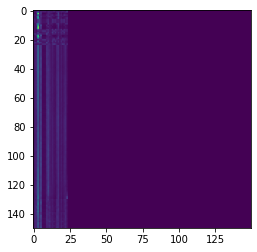

In [ ]:
attention = list(map(lambda t: t.cpu().detach().numpy(), output[-1]))
plt.imshow(attention[0][0][0])

In [ ]:
output

Additional checkpoint validation and check for overfitting (avoid cases where train accuracy >> test accuracy)

## All the labels

In this section, we fine-tune a model for each label. By simply running the following cell, you can get fine-tuned models for all the labels.

Notes about building models of all the labels:
1. For different labels, we clean or preprocess the input differently if we want by passing in different `remove_punctuations`, `remove_stop_words`, and `remove_digits` arguments. By default, we remove extra white spaces.
2. Decreasing `max_len` can improve the training speed but it can hurt the model performance.
3. Although we have a variable called `batch_size`, the actual batch size during the training is `batch_size * grad_acc_steps` which is `Total train batch size` in the log message of the training. This is due to gradient accumulation. See more details about it [here](https://huggingface.co/docs/transformers/main/en/performance#gradient-accumulation).
4. If GPU memory size is not enough, consider lowering `batch_size` or `epochs` so that less data will be stored in GPU memory each time.
5. If GPU disk size is not enough, consider increasing `steps` so that less model checkpoints will be saved. 

### One-time Preprocessing

In [81]:
# Define the list of labels
LABELS = ["Cannabinoid", "Intoxication", "Medical", "Wellness", "Commoditization"]

In [82]:
# Define the preprocess function ###
def preprocess_function(examples):
    """
    Preprocess the description field
    ---
    Arguments:
    examples (str, List[str], List[List[str]]: the sequence or batch of sequences to be encoded/tokenized

    Returns:
    tokenized (transformers.BatchEncoding): tokenized descriptions 
    """
    tokenized = tokenizer(
        examples["straindescription"],
        padding=padding,
        truncation=truncation,
        max_length=max_len,
    )

    return tokenized

### Evaluation Metrics ###
val_eval = {}
metric_acc = load_metric("accuracy")
metric_f1 = load_metric("f1")
metric_precision = load_metric("precision")
metric_recall = load_metric("recall")
metric_auc = load_metric("roc_auc")

def compute_metrics(eval_pred):
    """
    Compute the metrics 
    ---
    Arguments:
    eval_pred (tuple): the predicted logits and truth labels

    Returns:
    metrics (dict{str: float}): contains the computed metrics 
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    prediction_scores = np.max(logits, axis=-1)
    print(logits.shape, labels.shape)
    print(predictions.shape, prediction_scores.shape)

    pred_true = np.count_nonzero(predictions)
    pred_false = predictions.shape[0] - pred_true
    actual_true = np.count_nonzero(labels)
    actual_false = labels.shape[0] - actual_true

    acc = metric_acc.compute(predictions=predictions, references=labels)['accuracy']
    f1 = metric_f1.compute(predictions=predictions, references=labels)['f1']
    precision = metric_precision.compute(predictions=predictions, references=labels)['precision']
    recall = metric_recall.compute(predictions=predictions, references=labels)['recall']
    roc_auc = metric_auc.compute(prediction_scores=predictions, references=labels)['roc_auc']
    matthews_correlation = matthews_corrcoef(y_true=labels, y_pred=predictions)
    cohen_kappa = cohen_kappa_score(y1=labels, y2=predictions)

    tn, fp, fn, tp = confusion_matrix(y_true=labels, y_pred=predictions).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    informedness = specificity + sensitivity - 1

    metrics = {
        "pred_true": pred_true,
        "pred_false": pred_false,
        "actual_true": actual_true,
        "actual_false": actual_false,
        "accuracy": acc,
        "f1_score": f1,
        "precision": precision,
        "recall": recall,
        "roc_auc": roc_auc,
        "matthews_correlation": matthews_correlation,
        "cohen_kappa": cohen_kappa,
        "true_negative": tn,
        "false_positive": fp,
        "false_negative": fn,
        "true_positive": tp,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "informedness": informedness
    }
    return metrics

In [83]:
### Preprocess Setup ###
# Dataset Splitting Hyperparameters
val_size = 0.2 # validation set size
random_state = 10 # random seed 

# Tokenization Hyperparameters
padding = 'max_length' # padding strategy
padding_side = 'right' # the side on which the model should have padding applied
truncation = True # truncate strategy
truncation_side = 'right' # the side on which the model should have truncation applied
max_len = 150 # maximum length to use by one of the truncation/padding parameters

# Load the pre-trained tokenmizer ###
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    padding_side=padding_side,
    truncation_side=truncation_side
)

### Training and Model Setup ###
# model hyperparameters
classifier_dropout = 0.15 # dropout ratio for the classification head
num_classes = 2 # number of classes

# optimization hyperparameters ###
seed = 42 # random seed for splitting the data into batches
batch_size = 16 # batch size for both training and evaluation
grad_acc_steps = 4 # number of steps for gradient accumulation
lr = 5e-5 # initial learning rate
weight_decay = 2e-3 # weight decay to apply in the AdamW optimizer
epochs = 4 # total number of training epochs 
lr_scheduler = "cosine" # type of learning rate scheduler
strategy = "epoch" # strategy for logging, evaluation, and saving
steps = 100 # number of steps for logging, evaluation, and saving
eval_metric = "f1_score" # metric for selecting the best model
warmup_steps = 0 # number of "warmup" steps with reduced learning rate to warm up the model
output_attentions = True # controls whether attention matrices are output

# optimized hyperparameters from single-label case
# TODO: get best hyperparameters from Optuna db file
best_hp = {'classifier_dropout': 0.15000951233705967, 'learning_rate': 3.837936994956064e-05, 'warmup_steps': 40.0, 'weight_decay': 0.14999589089115756}
optimized_lr = best_hp['learning_rate']
optimized_weight_decay = best_hp['weight_decay']
optimized_warmup_steps = best_hp['warmup_steps']
optimized_classifier_dropout = best_hp['classifier_dropout']

# load the datasets
raw_insample = pd.read_csv("in_sample.csv")
raw_outsample = pd.read_csv("out_sample.csv")
clean_insample, clean_outsample = load_data("straindescription", LABELS, minimal=True)
train, val = train_test_split(clean_insample, test_size=val_size, random_state=random_state)
train.to_csv('train.csv', index=False)
val.to_csv('val.csv', index=False)
dataset = load_dataset('csv', data_files={'train': ['train.csv'], 'val': ['val.csv'], 'test': ['clean_out_sample.csv']})

# preprocess the textual input 
tokenized_dataset = dataset.map(preprocess_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns("straindescription")


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resolve/ma

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-48d108c39eaa4138/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

### Fine-tune BERT for each label separately

In [69]:
### Training ###
# fine-tune a separate model for each label
# train two models for each label, using tuned and default parameters
for label in LABELS:
    # try to free memory to avoid running out of memory
    torch.cuda.empty_cache()

    # set up directory paths
    model_dir_default = "bert_" + label + "_default"
    best_model_dir_default = "best_" + model_dir_default
    best_model_dir_zip_default = "best_" + model_dir_default + ".zip"
    !rm -rf $model_dir_default $best_model_dir_default $best_model_dir_zip_default # remove possible cache

    # remove other labels and rename the target label
    other_labels = list(filter(lambda x: x != label, LABELS))
    tokenized_dataset_label = tokenized_dataset.remove_columns(other_labels)
    tokenized_dataset_label = tokenized_dataset_label.rename_column(label, "label")

    # load the pre-trained model
    model_default = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        classifier_dropout=classifier_dropout,
        num_labels=num_classes,
    )

    # set up the training arguments
    training_args_default = TrainingArguments(
        output_dir=model_dir_default,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        gradient_accumulation_steps=grad_acc_steps,
        learning_rate=lr,
        weight_decay=weight_decay, 
        num_train_epochs=epochs,
        lr_scheduler_type=lr_scheduler,
        evaluation_strategy=strategy,
        logging_strategy=strategy, 
        save_strategy=strategy,
        eval_steps=steps,
        logging_steps=steps,
        save_steps=steps,
        seed=seed,
        load_best_model_at_end=True,
        metric_for_best_model=eval_metric,
        warmup_steps=warmup_steps,
        report_to="none"
    )

    # set up the trainer 
    trainer_default = Trainer(
        model=model_default,
        args=training_args_default,
        train_dataset=tokenized_dataset_label['train'],
        eval_dataset=tokenized_dataset_label['val'],
        tokenizer=tokenizer,   
        compute_metrics=compute_metrics,
    )

    # train (fine-tune) the model
    trainer_default.train()

    # evaluate the best model
    val_predictions_default = trainer_default.predict(tokenized_dataset["val"])
    val_eval[label + "_default"] = val_predictions_default.metrics
    test_predictions_default = trainer_default.predict(tokenized_dataset["test"])
    test_eval[label + "_default"] = test_predictions_default.metrics

    # clear folder to save storage
    !rm -r $model_dir_default

    # save the best model
    model_default.save_pretrained(best_model_dir_default)
    # !zip -r $best_model_dir_zip_default $best_model_dir_default

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": 0.15,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

https://huggingface.co/bert-base-uncased/resolve/main/pytorch_mo

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
creating metadata file for /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.d

Epoch,Training Loss,Validation Loss,Pred True,Pred False,Actual True,Actual False,Accuracy,F1 Score,Precision,Recall,Roc Auc,Matthews Correlation,Cohen Kappa,True Negative,False Positive,False Negative,True Positive,Specificity,Sensitivity,Informedness
0,0.160300,0.103068,899,921,908,912,0.970879,0.970670,0.975528,0.965859,0.970868,0.941803,0.941757,890,22,31,877,0.975877,0.965859,0.941736
1,0.086500,0.114953,900,920,908,912,0.969231,0.969027,0.973333,0.964758,0.969221,0.938496,0.938460,888,24,32,876,0.973684,0.964758,0.938442
2,0.060900,0.108547,909,911,908,912,0.967582,0.967529,0.966997,0.968062,0.967583,0.935165,0.935165,882,30,29,879,0.967105,0.968062,0.935167
3,0.042700,0.126640,898,922,908,912,0.965934,0.965670,0.971047,0.960352,0.965922,0.931922,0.931866,886,26,36,872,0.971491,0.960352,0.931844


***** Running Evaluation *****
  Num examples = 1820
  Batch size = 16


(1820, 2) (1820,)
(1820,) (1820,)


Saving model checkpoint to bert_Commoditization_default/checkpoint-113
Configuration saved in bert_Commoditization_default/checkpoint-113/config.json
Model weights saved in bert_Commoditization_default/checkpoint-113/pytorch_model.bin
tokenizer config file saved in bert_Commoditization_default/checkpoint-113/tokenizer_config.json
Special tokens file saved in bert_Commoditization_default/checkpoint-113/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1820
  Batch size = 16


(1820, 2) (1820,)
(1820,) (1820,)


Saving model checkpoint to bert_Commoditization_default/checkpoint-226
Configuration saved in bert_Commoditization_default/checkpoint-226/config.json
Model weights saved in bert_Commoditization_default/checkpoint-226/pytorch_model.bin
tokenizer config file saved in bert_Commoditization_default/checkpoint-226/tokenizer_config.json
Special tokens file saved in bert_Commoditization_default/checkpoint-226/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1820
  Batch size = 16


(1820, 2) (1820,)
(1820,) (1820,)


Saving model checkpoint to bert_Commoditization_default/checkpoint-339
Configuration saved in bert_Commoditization_default/checkpoint-339/config.json
Model weights saved in bert_Commoditization_default/checkpoint-339/pytorch_model.bin
tokenizer config file saved in bert_Commoditization_default/checkpoint-339/tokenizer_config.json
Special tokens file saved in bert_Commoditization_default/checkpoint-339/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1820
  Batch size = 16


(1820, 2) (1820,)
(1820,) (1820,)


Saving model checkpoint to bert_Commoditization_default/checkpoint-452
Configuration saved in bert_Commoditization_default/checkpoint-452/config.json
Model weights saved in bert_Commoditization_default/checkpoint-452/pytorch_model.bin
tokenizer config file saved in bert_Commoditization_default/checkpoint-452/tokenizer_config.json
Special tokens file saved in bert_Commoditization_default/checkpoint-452/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from bert_Commoditization_default/checkpoint-113 (score: 0.9706696181516326).
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Commoditization. If Commoditization are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1820
  Batch size = 16


The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Commoditization. If Commoditization are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 5578
  Batch size = 16
Configuration saved in best_bert_Commoditization_default/config.json
Model weights saved in best_bert_Commoditization_default/pytorch_model.bin


In [70]:
for label in LABELS:
    # try to free memory to avoid running out of memory
    torch.cuda.empty_cache()

    # load the datasets
    raw_insample = pd.read_csv("in_sample.csv")
    raw_outsample = pd.read_csv("out_sample.csv")
    clean_insample, clean_outsample = load_data("straindescription", LABELS, minimal=True)
    train, val = train_test_split(clean_insample, test_size=val_size, random_state=random_state)
    train.to_csv('train.csv', index=False)
    val.to_csv('val.csv', index=False)
    dataset = load_dataset('csv', data_files={'train': ['train.csv'], 'val': ['val.csv'], 'test': ['clean_out_sample.csv']})

    # preprocess the textual input 
    tokenized_dataset = dataset.map(preprocess_function, batched=True)
    tokenized_dataset = tokenized_dataset.remove_columns("straindescription")

    # set up directory paths
    model_dir = "bert_" + label
    best_model_dir = "best_" + model_dir
    best_model_dir_zip = "best_" + model_dir + ".zip"
    !rm -rf $model_dir $best_model_dir $best_model_dir_zip # remove possible cache

    # remove other labels and rename the target label
    other_labels = list(filter(lambda x: x != label, LABELS))
    tokenized_dataset_label = tokenized_dataset.remove_columns(other_labels)
    tokenized_dataset_label = tokenized_dataset_label.rename_column(label, "label")

    # load the pre-trained model
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        classifier_dropout=optimized_classifier_dropout,
        num_labels=num_classes,
    )

    training_args = TrainingArguments(
        output_dir=model_dir,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        gradient_accumulation_steps=grad_acc_steps,
        learning_rate=optimized_lr,
        weight_decay=optimized_weight_decay, 
        num_train_epochs=epochs,
        lr_scheduler_type=lr_scheduler,
        evaluation_strategy=strategy,
        logging_strategy=strategy, 
        save_strategy=strategy,
        eval_steps=steps,
        logging_steps=steps,
        save_steps=steps,
        seed=seed,
        load_best_model_at_end=True,
        metric_for_best_model=eval_metric,
        warmup_steps=optimized_warmup_steps,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset_label['train'],
        eval_dataset=tokenized_dataset_label['val'],
        tokenizer=tokenizer,   
        compute_metrics=compute_metrics,
    )

    # train (fine-tune) the model
    trainer.train()

    # evaluate the best model
    val_predictions = trainer.predict(tokenized_dataset["val"])
    val_eval[label] = val_predictions.metrics
    test_predictions = trainer.predict(tokenized_dataset["test"])
    test_eval[label] = test_predictions.metrics

    # save the best model
    model.save_pretrained(best_model_dir)
    # !zip -r $best_model_dir_zip $best_model_dir

    # clear the folder to save space
    !rm -r $model_dir

Using custom data configuration default-67da0dc5b20e2436


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-67da0dc5b20e2436/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": 0.15000951233705967,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-

Epoch,Training Loss,Validation Loss,Pred True,Pred False,Actual True,Actual False,Accuracy,F1 Score,Precision,Recall,Roc Auc,Matthews Correlation,Cohen Kappa,True Negative,False Positive,False Negative,True Positive,Specificity,Sensitivity,Informedness
0,0.235500,0.117949,880,940,908,912,0.961538,0.960850,0.976136,0.946035,0.961504,0.923509,0.923071,891,21,49,859,0.976974,0.946035,0.923009
1,0.097700,0.113708,900,920,908,912,0.967033,0.966814,0.971111,0.962555,0.967023,0.934100,0.934064,886,26,34,874,0.971491,0.962555,0.934046
2,0.067700,0.111277,910,910,908,912,0.967033,0.966997,0.965934,0.968062,0.967035,0.934068,0.934066,881,31,29,879,0.966009,0.968062,0.934070
3,0.050200,0.122938,900,920,908,912,0.965934,0.965708,0.970000,0.961454,0.965924,0.931902,0.931866,885,27,35,873,0.970395,0.961454,0.931848


***** Running Evaluation *****
  Num examples = 1820
  Batch size = 16


(1820, 2) (1820,)
(1820,) (1820,)


Saving model checkpoint to bert_Commoditization/checkpoint-113
Configuration saved in bert_Commoditization/checkpoint-113/config.json
Model weights saved in bert_Commoditization/checkpoint-113/pytorch_model.bin
tokenizer config file saved in bert_Commoditization/checkpoint-113/tokenizer_config.json
Special tokens file saved in bert_Commoditization/checkpoint-113/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1820
  Batch size = 16


(1820, 2) (1820,)
(1820,) (1820,)


Saving model checkpoint to bert_Commoditization/checkpoint-226
Configuration saved in bert_Commoditization/checkpoint-226/config.json
Model weights saved in bert_Commoditization/checkpoint-226/pytorch_model.bin
tokenizer config file saved in bert_Commoditization/checkpoint-226/tokenizer_config.json
Special tokens file saved in bert_Commoditization/checkpoint-226/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1820
  Batch size = 16


(1820, 2) (1820,)
(1820,) (1820,)


Saving model checkpoint to bert_Commoditization/checkpoint-339
Configuration saved in bert_Commoditization/checkpoint-339/config.json
Model weights saved in bert_Commoditization/checkpoint-339/pytorch_model.bin
tokenizer config file saved in bert_Commoditization/checkpoint-339/tokenizer_config.json
Special tokens file saved in bert_Commoditization/checkpoint-339/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1820
  Batch size = 16


(1820, 2) (1820,)
(1820,) (1820,)


Saving model checkpoint to bert_Commoditization/checkpoint-452
Configuration saved in bert_Commoditization/checkpoint-452/config.json
Model weights saved in bert_Commoditization/checkpoint-452/pytorch_model.bin
tokenizer config file saved in bert_Commoditization/checkpoint-452/tokenizer_config.json
Special tokens file saved in bert_Commoditization/checkpoint-452/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from bert_Commoditization/checkpoint-339 (score: 0.9669966996699669).
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Commoditization. If Commoditization are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1820
  Batch size = 16


The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Commoditization. If Commoditization are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 5578
  Batch size = 16
Configuration saved in best_bert_Commoditization/config.json
Model weights saved in best_bert_Commoditization/pytorch_model.bin


### Load and evaluate each network

In [76]:
# Load and evaluate each model
with torch.no_grad():
  for suffix in ["", "_default"]:
    # evaluate with both optimized and default hyperparameters
    for label in LABELS:
        # load the dataset
        raw_insample = pd.read_csv("in_sample.csv")
        raw_outsample = pd.read_csv("out_sample.csv")
        clean_insample, clean_outsample = load_data("straindescription", LABELS, minimal=True)
        train, val = train_test_split(clean_insample, test_size=val_size, random_state=random_state)
        train.to_csv('train.csv', index=False)
        val.to_csv('val.csv', index=False)
        dataset = load_dataset('csv', data_files={'train': ['train.csv'], 'val': ['val.csv'], 'test': ['clean_out_sample.csv']})

        # preprocess the textual input 
        tokenized_dataset = dataset.map(preprocess_function, batched=True)
        tokenized_dataset = tokenized_dataset.remove_columns("straindescription")

        # set up directory paths
        model_dir = "bert_" + label
        best_model_dir = "best_" + model_dir
        best_model_dir_default = best_model_dir + "_default"      

        # remove other labels and rename the target label
        other_labels = list(filter(lambda x: x != label, LABELS))
        tokenized_dataset_label = tokenized_dataset.remove_columns(other_labels)
        tokenized_dataset_label = tokenized_dataset_label.rename_column(label, "label")

        # load the saved model
        print(f'Loading from {best_model_dir}')
        model = AutoModelForSequenceClassification.from_pretrained(
            best_model_dir
        )

        training_args = TrainingArguments(
          output_dir=model_dir,
          per_device_train_batch_size=batch_size,
          per_device_eval_batch_size=batch_size,
          gradient_accumulation_steps=grad_acc_steps,
          learning_rate=optimized_lr,
          weight_decay=optimized_weight_decay, 
          num_train_epochs=epochs,
          lr_scheduler_type=lr_scheduler,
          evaluation_strategy=strategy,
          logging_strategy=strategy, 
          save_strategy=strategy,
          eval_steps=steps,
          logging_steps=steps,
          save_steps=steps,
          seed=seed,
          load_best_model_at_end=True,
          metric_for_best_model=eval_metric,
          warmup_steps=optimized_warmup_steps,
          report_to="none"
        )

        training_args_default = TrainingArguments(
          output_dir=model_dir,
          per_device_train_batch_size=batch_size,
          per_device_eval_batch_size=batch_size,
          gradient_accumulation_steps=grad_acc_steps,
          learning_rate=lr,
          weight_decay=weight_decay, 
          num_train_epochs=epochs,
          lr_scheduler_type=lr_scheduler,
          evaluation_strategy=strategy,
          logging_strategy=strategy, 
          save_strategy=strategy,
          eval_steps=steps,
          logging_steps=steps,
          save_steps=steps,
          seed=seed,
          load_best_model_at_end=True,
          metric_for_best_model=eval_metric,
          warmup_steps=warmup_steps,
          report_to="none"
          )
        
        label = label + suffix

        trainer = Trainer(
            model=model,
            args=training_args_default if "_default" in label else training_args,
            train_dataset=tokenized_dataset_label['train'],
            eval_dataset=tokenized_dataset_label['val'],
            tokenizer=tokenizer,   
            compute_metrics=compute_metrics,
        )

        # evaluate the best model
        val_eval[label] = trainer.evaluate()


Using custom data configuration default-d1d2215cdbe2f9c9


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-d1d2215cdbe2f9c9/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

loading configuration file best_bert_Commoditization/config.json
Model config BertConfig {
  "_name_or_path": "best_bert_Commoditization",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": 0.15000951233705967,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file best_bert_Commoditization/pytorch_model.bin


Loading from best_bert_Commoditization


All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the model checkpoint at best_bert_Commoditization.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.
PyTorch: setting up devices
PyTorch: setting up devices
***** Running Evaluation *****
  Num examples = 1820
  Batch size = 16


(1820, 2) (1820,)
(1820,) (1820,)


Using custom data configuration default-bbd32885f9e0fb5a


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-bbd32885f9e0fb5a/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

loading configuration file best_bert_Commoditization/config.json
Model config BertConfig {
  "_name_or_path": "best_bert_Commoditization",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": 0.15000951233705967,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file best_bert_Commoditization/pytorch_model.bin


Loading from best_bert_Commoditization


All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the model checkpoint at best_bert_Commoditization.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.
PyTorch: setting up devices
PyTorch: setting up devices
***** Running Evaluation *****
  Num examples = 1820
  Batch size = 16


(1820, 2) (1820,)
(1820,) (1820,)


In [72]:
# save the evaluation result of each model
val_eval_df = pd.DataFrame.from_dict(val_eval).transpose()
val_eval_df.to_csv("val_evaluation.csv")

In [ ]:
model

### Multi Label Classifier

In [84]:
### Preprocess Setup ###
# Dataset Splitting Hyperparameters
val_size = 0.2 # validation set size
random_state = 10 # random seed 

# Tokenization Hyperparameters
padding = 'max_length' # padding strategy
padding_side = 'right' # the side on which the model should have padding applied
truncation = True # truncate strategy
truncation_side = 'right' # the side on which the model should have truncation applied
max_len = 150 # maximum length to use by one of the truncation/padding parameters

# Load the pre-trained tokenmizer ###
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    padding_side=padding_side,
    truncation_side=truncation_side
)

# Re-define the preprocess function ###
def preprocess_function(examples):
    """
    Preprocess the description field
    ---
    Arguments:
    examples (str, List[str], List[List[str]]: the sequence or batch of sequences to be encoded/tokenized

    Returns:
    tokenized (transformers.BatchEncoding): tokenized descriptions 
    """
    tokenized = tokenizer(
        examples["straindescription"],
        padding=padding,
        truncation=truncation,
        max_length=max_len
    )

    labels_batch = {k: examples[k] for k in examples.keys() if k in LABELS}
    labels_matrix = np.zeros((len(examples["straindescription"]), len(LABELS)))

    for idx, label in enumerate(LABELS):
        labels_matrix[:, idx] = labels_batch[label]

    tokenized['labels'] = labels_matrix.tolist()

    return tokenized

### Training and Model Setup ###
# model hyperparameters
classifier_dropout = 0.15 # dropout ratio for the classification head
num_classes = len(LABELS) # number of classes

# optimization hyperparameters ###
seed = 42 # random seed for splitting the data into batches
batch_size = 32 # batch size for both training and evaluation
grad_acc_steps = 2 # number of steps for gradient accumulation
lr = 5e-5 # initial learning rate
weight_decay = 2e-3 # weight decay to apply in the AdamW optimizer
epochs = 3 # total number of training epochs 
lr_scheduler = "cosine" # type of learning rate scheduler
strategy = "steps" # strategy for logging, evaluation, and saving
steps = 100 # number of steps for logging, evaluation, and saving
eval_metric = "f1_score" # metric for selecting the best model
warmup_steps = 0 # number of "warmup" steps with reduced learning rate to warm up the model

### Training ###
# load the datasets
raw_insample = pd.read_csv("in_sample.csv")
raw_outsample = pd.read_csv("out_sample.csv")
clean_insample, clean_outsample = load_data("straindescription", LABELS, minimal=True)
train, val = train_test_split(clean_insample, test_size=val_size, random_state=random_state)
train.to_csv('train.csv', index=False)
val.to_csv('val.csv', index=False)
dataset = load_dataset('csv', data_files={'train': ['train.csv'], 'val': ['val.csv'], 'test': ['clean_out_sample.csv']})

# preprocess the textual input 
tokenized_dataset = dataset.map(preprocess_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["straindescription"] + LABELS)

# set up directory paths
model_dir_ = "bert_" + "All"
best_model_dir = "best_" + model_dir
best_model_dir_zip = "best_" + model_dir + ".zip"
!rm -rf $model_dir $best_model_dir $best_model_dir_zip # remove possible cache

# load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    classifier_dropout=classifier_dropout,
    num_labels=num_classes,
    problem_type="multi_label_classification"
)

# set up the training arguments
training_args = TrainingArguments(
    output_dir=model_dir,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=grad_acc_steps,
    learning_rate=lr,
    weight_decay=weight_decay, 
    num_train_epochs=epochs,
    lr_scheduler_type=lr_scheduler,
    evaluation_strategy=strategy,
    logging_strategy=strategy, 
    save_strategy=strategy,
    eval_steps=steps,
    logging_steps=steps,
    save_steps=steps,
    seed=seed,
    load_best_model_at_end=True,
    metric_for_best_model=eval_metric,
    report_to="none",
    warmup_steps=warmup_steps
)

# set up the trainer 
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    tokenizer=tokenizer,   
    compute_metrics=compute_metrics,
)



loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resolve/ma

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-a51427bc44d64805/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": 0.15,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  

In [89]:
# verify the multi-label dataset. 'labels' should be a list of 0 and 1 values.
trainer.train_dataset[0]['labels']

[0.0, 1.0, 0.0, 0.0, 0.0]

In [90]:
# train (fine-tune) the model
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 7276
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 2
  Total optimization steps = 342


Step,Training Loss,Validation Loss


***** Running Evaluation *****
  Num examples = 1819
  Batch size = 32


(1819, 5) (1819, 5)
(1819,) (1819,)


TypeError: ignored

In [ ]:
# evaluate the best model
val_predictions = trainer.predict(tokenized_dataset_label["val"])
val_eval = val_predictions.metrics
test_predictions = trainer.predict(tokenized_dataset_label["test"])
test_eval = test_predictions.metrics

# save the best model
model.save_pretrained(best_model_dir)
# !zip -r $best_model_dir_zip $best_model_dir

# save the evaluation result of each model
val_eval_df = pd.DataFrame.from_dict(val_eval).transpose()
val_eval_df.to_csv("val_evaluation.csv")
test_eval_df = pd.DataFrame.from_dict(test_eval).transpose()
test_eval_df.to_csv("test_evaluation.csv")

## Prediction

In this section, we deploy the fine-tuned models to make predictions on the real data that will be used for another data analysis.

Same as the previous setup of the fine-tuning, you need to upload the real data `full_dataset.csv`.

In [ ]:
LABELS = ["Cannabinoid", "Intoxication", "Medical", "Wellness", "Commoditization"]
# LABELS = ["Wellness", "Commoditization"]
# LABELS = ["Cannabinoid", "Intoxication", "Medical"]

full_dataset = pd.read_csv("full_dataset.csv")

In [ ]:
# # downsampling
# full_dataset = full_dataset.sample(50000, random_state=random_state)

Clean the real data for getting passed into the model

In [ ]:
full_dataset['straindescription'] = '"' + full_dataset['strain'].astype(str) + '" -- '+ full_dataset['description'].astype(str)
clean_full = clean_data(full_dataset, "straindescription", [], minimal=True)

Define functions and hyperparmeters needed for making predictions.

**Warning:** The hyperparameter choices here should be the **same** as those in fine-tuning stage.

In [ ]:
### Preprocess Setup ###
# Tokenization Hyperparameters
padding = 'max_length' # padding strategy
padding_side = 'right' # the side on which the model should have padding applied
truncation = True # truncate strategy
truncation_side = 'right' # the side on which the model should have truncation applied
max_len = 150 # maximum length to use by one of the truncation/padding parameters

# Load the pre-trained tokenmizer ###
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    padding_side=padding_side,
    truncation_side=truncation_side
)

# Define the preprocess function ###
def preprocess_function(examples):
    """
    Preprocess the description field
    ---
    Arguments:
    examples (str, List[str], List[List[str]]: the sequence or batch of sequences to be encoded/tokenized

    Returns:
    tokenized (transformers.BatchEncoding): tokenized descriptions 
    """
    tokenized = tokenizer(
        examples["straindescription"],
        padding=padding,
        truncation=truncation,
        max_length=max_len
    )

    return tokenized

Predict each label on the real data

In [ ]:
# preprocess the textual input 
dataset = Dataset.from_pandas(clean_full)
tokenized_dataset = dataset.map(preprocess_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["straindescription", "__index_level_0__"])

for label in LABELS:

    # set up directory paths
    best_model_dir = "best_bert_" + label

    model = AutoModelForSequenceClassification.from_pretrained(best_model_dir)

    trainer = Trainer(
        model=model,
    )

    predictions = trainer.predict(tokenized_dataset)
    predict_labels = np.argmax(predictions.predictions, axis=-1)
    full_dataset[(label+"_labeled").lower()] = predict_labels

# manipulate the dataframe so that it is acceptable to another data analysis code
full_dataset = full_dataset.rename({"medical_labeled":"medical_undersampled_labeled"}, axis=1)
full_dataset["medical_labeled"] = np.zeros(full_dataset.shape[0])
full_dataset["medical_labeled"] = full_dataset["medical_labeled"].astype(int)
full_dataset["smellflavor_labeled"] = np.zeros(full_dataset.shape[0])
full_dataset["smellflavor_labeled"] = full_dataset["smellflavor_labeled"].astype(int)
full_dataset["genetics_labeled"] = np.zeros(full_dataset.shape[0])
full_dataset["genetics_labeled"] = full_dataset["genetics_labeled"].astype(int)
full_dataset.to_csv("full_dataset_with_labels.csv", index=False, line_terminator='\r\n')
